### 0. Import the Libraries

In [1]:
import pickle
from chart_studio import plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
from datetime import datetime
from collections import Counter
import itertools
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os

from sklearn.model_selection import GridSearchCV
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from imblearn.combine import SMOTEENN

from xgboost import XGBClassifier


## 1. Loading and Preparing Data

### Reading and merge dataset

In [2]:
df_18 = pd.read_csv("./data/Chicago_Crimes_2018.csv")
df_19 = pd.read_csv("./data/Chicago_Crimes_2019.csv")
df_20 = pd.read_csv("./data/Chicago_Crimes_2020.csv")
df_21 = pd.read_csv("./data/Chicago_Crimes_2021.csv")
df_22 = pd.read_csv("./data/Chicago_Crimes_2022.csv")
df_23 = pd.read_csv("./data/Chicago_Crimes_2023.csv")
df_raw = pd.concat([df_18, df_19, df_20, df_21, df_22, df_23], ignore_index=True)

In [3]:
df_raw.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [4]:
selected_columns = ['Date', 'Latitude', 'Longitude', 'Arrest']
df = df_raw[selected_columns]

In [5]:
df.head()

,Date,Latitude,Longitude,Arrest
0,11/09/2018 12:00:00 AM,41.911574,-87.789972,False
1,09/15/2018 08:00:00 AM,NaN,NaN,True
2,09/30/2018 01:05:00 PM,41.694643,-87.661565,False
3,09/01/2018 12:00:00 AM,NaN,NaN,False
4,12/14/2018 02:45:00 PM,NaN,NaN,False


In [6]:
print("{:,} total crime records".format(len(df)))

1,373,071 total crime records


### Drop the duplicates

In [7]:
df = df.drop_duplicates()
print("{:,} total crime records after removing duplicates".format(len(df)))

1,360,210 total crime records after removing duplicates


### Break up date into components

In [8]:
def break_up_date(str_date):
    date_format = '%m/%d/%Y %I:%M:%S %p'
    date = datetime.strptime(str_date, date_format)
    return date

years = []
months = []
days = []
hours = []
minutes = []
for date in map(break_up_date,df['Date']):
    years.append(date.year)
    months.append(date.month)
    days.append(date.day)
    hours.append(date.hour)
    minutes.append(date.minute)
df['Year'] = years
df['Month'] = months
df['Day'] =  days
df['Hour'] = hours
df['Minute'] = minutes

In [9]:
df.drop('Date',axis=1,inplace=True)

In [10]:
df.head()

,Latitude,Longitude,Arrest,Year,Month,Day,Hour,Minute
0,41.911574,-87.789972,False,2018,11,9,0,0
1,NaN,NaN,True,2018,9,15,8,0
2,41.694643,-87.661565,False,2018,9,30,13,5
3,NaN,NaN,False,2018,9,1,0,0
4,NaN,NaN,False,2018,12,14,14,45


### Drop NA values

In [11]:
df.dropna(axis=0,how='any', inplace=True)
print("{:,} total crime records after removing NAs".format(len(df)))

1,340,842 total crime records after removing NAs


In [57]:
df.head()
# df["Arrest"].value_counts()

,Latitude,Longitude,Arrest,Year,Month,Day,Hour,Minute
0,41.911574,-87.789972,False,2018,11,9,0,0
2,41.694643,-87.661565,False,2018,9,30,13,5
10,41.998188,-87.697224,False,2018,1,1,0,1
11,41.872699,-87.688629,True,2018,9,1,11,49
16,41.764193,-87.652879,False,2018,5,1,0,0


In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Latitude,1340842.0,41.843570,0.087499,36.619446,41.767920,41.861563,41.906392,42.022671
Longitude,1340842.0,-87.669593,0.059803,-91.686566,-87.711952,-87.663048,-87.627298,-87.524529
Year,1340842.0,2020.319079,1.711073,2018.000000,2019.000000,2020.000000,2022.000000,2023.000000
Month,1340842.0,6.396638,3.301088,1.000000,4.000000,6.000000,9.000000,12.000000
Day,1340842.0,15.567696,8.856577,1.000000,8.000000,15.000000,23.000000,31.000000
Hour,1340842.0,12.782869,6.746426,0.000000,8.000000,14.000000,18.000000,23.000000
Minute,1340842.0,19.860324,18.708079,0.000000,0.000000,18.000000,33.000000,59.000000


### Convert df data to array type

In [23]:
y = np.asarray(df[['Arrest']])
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

# X = df[['Latitude','Longitude','Month','Day','Hour','Minute']]
X = df[['Latitude','Longitude','Hour','Minute']]
X = X.to_dict(orient='records')
vec = DictVectorizer()
X = vec.fit_transform(X).toarray()

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



### Balancing data

In [24]:
print("Count of each target from unbalanced dataset: {} (arrest true (1) or false (0))".format(sorted(Counter(y).items())))
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
print("Count of each target from balanced dataset: {} (arrest true (1) or false (0))".format(sorted(Counter(y_resampled).items())))

Count of each target from unbalanced dataset: [(0, 1125417), (1, 215425)] (arrest true (1) or false (0))
Count of each target from balanced dataset: [(0, 604855), (1, 649372)] (arrest true (1) or false (0))


### Split data into train and test set

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.2, random_state=42)

### Normalize the input features

In [26]:
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.transform(X_test)
# y_train2 = scaler.fit_transform(y_train)

In [27]:
print(X)

[[  0.          41.91157425 -87.78997228   0.        ]
 [ 13.          41.69464271 -87.66156517   5.        ]
 [  0.          41.99818822 -87.69722366   1.        ]
 ...
 [  7.          41.89071813 -87.74811127  35.        ]
 [ 21.          41.79176316 -87.65724073  25.        ]
 [ 12.          41.87622373 -87.72191251  42.        ]]


## 2. Modeling, Prediction and Evaluation

### Using K-Nearest Neighbors

In [65]:
parameters = { 
    'n_neighbors':[5,7,9],
    'weights':['uniform', 'distance']
}
knn = KNeighborsClassifier();
grid_knn = GridSearchCV(estimator=knn, param_grid=parameters, verbose=0);
grid_knn.fit(X_train, y_train);

In [66]:
print(grid_knn.best_params_)
print(grid_knn.best_score_)
print(grid_knn.best_estimator_)
# print(grid_lr.feature_importances_)

{'n_neighbors': 5, 'weights': 'distance'}
0.953401727861771
KNeighborsClassifier(weights='distance')


{'n_neighbors': 5, 'weights': 'distance'}
0.8260319336773744
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [67]:
grid_knn.best_estimator_.fit(X_train, y_train);

In [82]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance');
knn.fit(X_train2,y_train)

knn_expected = y_test
knn_predicted = knn.predict(X_test)
knn_cm = metrics.confusion_matrix(knn_expected, knn_predicted)

print("Accuracy={}".format(metrics.accuracy_score(knn_expected, knn_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(knn_expected, knn_predicted)))
print("Confusion matrix:\n%s" % knn_cm)


Accuracy=0.5174744024804976
Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.01      0.03    133342
           1       0.51      1.00      0.68    139829

    accuracy                           0.52    273171
   macro avg       0.70      0.51      0.35    273171
weighted avg       0.70      0.52      0.36    273171


Confusion matrix:
[[  1743 131599]
 [   213 139616]]


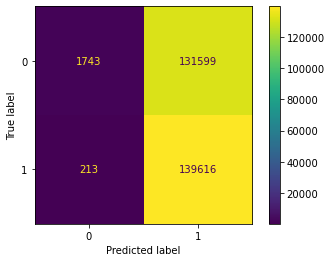

In [85]:
ConfusionMatrixDisplay.from_predictions(knn_expected, knn_predicted)
plt.show()

### Decision Tree

In [69]:
parameters = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2,4,5,6,7,8,9,10], 
    'min_samples_leaf':[2,4,6,8,10]
}
dt = DecisionTreeClassifier();
dt_start_time = datetime.now()
print('Start learning at {}'.format(str(dt_start_time)))
grid_dt = GridSearchCV(estimator=dt, param_grid=parameters, verbose=0);
grid_dt.fit(X_train, y_train);
dt_end_time = datetime.now() 
print('Stop learning {}'.format(str(dt_end_time)))
dt_elapsed_time= dt_end_time - dt_start_time
print('Elapsed learning {}'.format(str(dt_elapsed_time)))

Start learning at 2023-10-08 13:37:31.350316
Stop learning 2023-10-08 14:23:43.440638
Elapsed learning 0:46:12.090322


In [70]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)
print(grid_dt.best_estimator_)

{'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 9}
0.8294459494087931
DecisionTreeClassifier(max_features='auto', min_samples_leaf=10,
                       min_samples_split=9)


In [71]:
grid_dt.best_estimator_.fit(X_train, y_train);

In [73]:
dt_expected = y_test
dt_start_time_test = datetime.now()
print('Start testing at {}'.format(str(dt_start_time_test)))
dt_predicted = grid_dt.best_estimator_.predict(X_test)
dt_end_time_test = datetime.now() 
print('Stop testing {}'.format(str(dt_end_time_test)))
dt_elapsed_time_test = dt_end_time_test - dt_start_time_test
print('Elapsed testing {}'.format(str(dt_elapsed_time_test)))
dt_cm = metrics.confusion_matrix(dt_expected, dt_predicted)

Start testing at 2023-10-08 14:39:47.176103
Stop testing 2023-10-08 14:39:47.286144
Elapsed testing 0:00:00.110041


In [74]:
print("Accuracy={}".format(metrics.accuracy_score(dt_expected, dt_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(dt_expected, dt_predicted)))
print("Confusion matrix:\n%s" % dt_cm)

Accuracy=0.8306665055953963
Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    133342
           1       0.84      0.83      0.83    139829

    accuracy                           0.83    273171
   macro avg       0.83      0.83      0.83    273171
weighted avg       0.83      0.83      0.83    273171


Confusion matrix:
[[111366  21976]
 [ 24281 115548]]


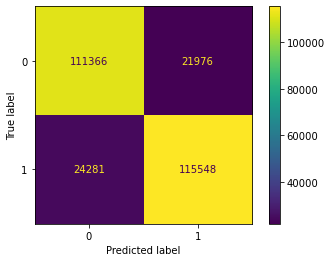

In [86]:
ConfusionMatrixDisplay.from_predictions(dt_expected, dt_predicted)
plt.show()

### XG-Boost

In [28]:
parameters = { 
    'max_depth' : [10],
    'n_estimators': [100,200],
    'booster': ['gbtree']
}
xgb = XGBClassifier();
xgb_start_time = datetime.now()
print('Start learning at {}'.format(str(xgb_start_time)))
grid_xgb = GridSearchCV(estimator=xgb, param_grid=parameters, verbose=0);
grid_xgb.fit(X_train, y_train);
xgb_end_time = datetime.now() 
print('Stop learning {}'.format(str(xgb_end_time)))
xgb_elapsed_time= xgb_end_time - xgb_start_time
print('Elapsed learning {}'.format(str(xgb_elapsed_time)))

Start learning at 2023-11-13 22:44:37.640681
Stop learning 2023-11-13 22:46:26.387982
Elapsed learning 0:01:48.747301


In [29]:
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)
print(grid_xgb.best_estimator_)

{'booster': 'gbtree', 'max_depth': 10, 'n_estimators': 200}
0.8966225197764766
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [30]:
grid_xgb.best_estimator_.fit(X_train2, y_train);

In [31]:
xgb = XGBClassifier(n_estimators=200,max_depth=10,booster='gbtree');
xgb.fit(X_train2, y_train);
xgb_expected = y_test
xgb_predicted = xgb.predict(X_test2)
xgb_cm = metrics.confusion_matrix(xgb_expected, xgb_predicted)

In [32]:
xgb_expected = y_test
xgb_start_time_test = datetime.now()
print('Start testing at {}'.format(str(xgb_start_time_test)))
xgb_predicted = xgb.predict(X_test2)
xgb_end_time_test = datetime.now() 
print('Stop testing {}'.format(str(xgb_end_time_test)))
xgb_elapsed_time_test = xgb_end_time_test - xgb_start_time_test
print('Elapsed testing {}'.format(str(xgb_elapsed_time_test)))
xgb_cm = metrics.confusion_matrix(xgb_expected, xgb_predicted)

Start testing at 2023-11-13 22:47:05.502793
Stop testing 2023-11-13 22:47:06.282797
Elapsed testing 0:00:00.780004


In [33]:
print("Accuracy={}".format(metrics.accuracy_score(xgb_expected, xgb_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("XG-Boost", metrics.classification_report(xgb_expected, xgb_predicted)))
print("Confusion matrix:\n%s" % xgb_cm)

Accuracy=0.900544557218373


Classification report for classifier XG-Boost:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90    121009
           1       0.89      0.92      0.91    129837

    accuracy                           0.90    250846
   macro avg       0.90      0.90      0.90    250846
weighted avg       0.90      0.90      0.90    250846


Confusion matrix:
[[106956  14053]
 [ 10895 118942]]


<Figure size 1800x1200 with 0 Axes>

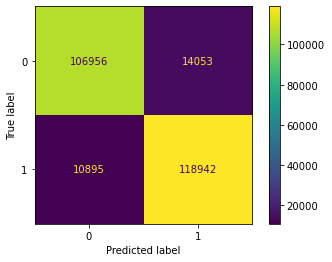

In [34]:
plt.figure(dpi=300)
ConfusionMatrixDisplay.from_predictions(xgb_expected, xgb_predicted)
plt.show()

## 3. Testing

In [97]:
Test = [16,5,41.876248,-87.653065,10,5]

In [98]:
print(grid_xgb.best_estimator_.predict(X_test))

[0 0 1 ... 0 0 1]


In [99]:
Test = np.array([[ 21, 0, 42.0122934 , -87.69971411, 15, 9]])
print(scaler.transform(Test))
Test2 = np.array([[-0.50714446,  0.70064672,  1.33995114, -1.07622397, -1.12694646, -0.47388072]])
scaler.transform(Test2)
print(xgb.predict(Test2))
print(xgb.predict_proba(Test2))

[[ 0.61286694 -1.94729926  2.0722281  -0.49585716 -0.35029065  0.79757858]]
[1]
[[7.1525574e-05 9.9992847e-01]]


In [104]:
Test = np.array([[ 21, 0, 42.0122934, -87.69971411, 15, 9]])
print(xgb.predict_proba(scaler.transform(Test)))

[[0.86673784 0.13326216]]


In [35]:
pickle.dump(scaler, open('./scaler.pkl', 'wb'))
pickle.dump(xgb, open('./xgboost.pkl', 'wb'))